### Part I
1.Import the necessary Libraries (uncomment "pip install" lines if installation is needed)

In [1]:
import pandas as pd
import numpy as np
#!pip install beautifulsoup4;
#!pip install matplotlib
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

In [3]:
print (train.shape, test.shape)

(25000, 3) (25000, 2)


2.Get rid of html tags, get rid of non-alphabets, output preprocessed tokens of words

In [4]:
def preprocess(String):
    out = BeautifulSoup(String, "html.parser")
    out = out.get_text()
    out_list = re.sub("[^a-zA-Z]"," ",out).lower().split()
    stop_words = set(stopwords.words("english"))
    out_list_clean = [words for words in out_list if words not in stop_words]
    out_clean = " ".join(out_list_clean)
    return out_clean

In [5]:
train.review = train.review.apply(lambda x: preprocess(x))
test.review = test.review.apply(lambda x: preprocess(x))

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

3.Vectorize,  Processing text to create design matrices

In [7]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None,max_features = 5000)

In [8]:
feature_set = vectorizer.fit_transform(train.review)
feature_set_test = vectorizer.transform(test.review)

In [9]:
X_counts = feature_set
X_counts_test = feature_set_test

Create Binary feature set

In [10]:
X_binary = feature_set
X_binary[X_binary >0] = 1

X_binary_test = feature_set_test
X_binary_test[X_binary_test >0] = 1

Create tfidf feature set

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

In [12]:
transformer = TfidfTransformer(smooth_idf=False)

In [13]:
X_tfidf = transformer.fit_transform(X_counts)
X_tfidf_test = transformer.transform(X_counts_test)

Create Imbalanced feature set, and label set

In [14]:
index_sentiment_1 = train.index[train.sentiment == 1]
index_sentiment_0 = train.index[train.sentiment == 0]
np.random.seed = 0

#only take 25% of the sentiment label==1
size = len(index_sentiment_1)*0.25
index_sampled = np.random.choice(index_sentiment_1, int(size), replace = False) 
indx = np.concatenate((index_sentiment_0, index_sampled))

In [15]:
X_binary_imbalanced = X_binary[indx]
y_label_imbalanced = train.sentiment[indx].values 

### Part II
1.create distance function

In [16]:
def dist(X,i,j, distance_function="Euclidean" ):
    dis_vector = X[i,:].toarray() - X[j,:].toarray()
    if distance_function == "Euclidean":
        return np.linalg.norm(dis_vector)
    else:
        return "distance method not supported"

In [17]:
print(dist(X_counts, 3,5))

11.0905365064


2.create top k function

In [28]:
from sklearn.metrics.pairwise import pairwise_distances
def topk(X,k):
    dist_matrix = pairwise_distances(X)
    n_point = dist_matrix.shape[0]
    #random permutation to break ties
    dist_matrix = np.random.permutation(dist_matrix)
    top_k = []
    #remove distance to self and duplicates
    dist_matrix[dist_matrix == 0] = 999999999
    
    #print("ready")
    
    for j in range(k):
        best_loc = np.argmin(dist_matrix)
        row = int(np.floor(best_loc/n_point))
        column = int(best_loc - row*n_point)
        top_k.append((row,column, dist_matrix[row,column]))
        #remove those that have been included in the top k from dist matrix
        dist_matrix[row,column] = 999999999 
        dist_matrix[column, row] = 999999999
    
    return top_k

In [19]:
topk_counts = topk(X_counts,5)

In [20]:
def print_everything(topk):
    for i in range(len(topk)):
        point1 = int(topk[i][0])
        point2 = int(topk[i][1])
        print ("top", i+1)
        print ("indices: ", point1, point2)
        print ("distance: ", topk[i][2])
        print ("first 20 character1: ", train.review[point1][:20], " ,first 20 character2: ",train.review[point2][:20])
        print ("label1 ", train.sentiment[point1], "label2 ",train.sentiment[point2])
        print ("")

In [21]:
print_everything(topk_counts)

top 1
indices:  430 11331
distance:  1.0
first 20 character1:  somebody owes ang le  ,first 20 character2:  saw theater fell cha
label1  0 label2  1

top 2
indices:  1586 13530
distance:  1.0
first 20 character1:  enjoy watching peopl  ,first 20 character2:  brothers psychokinet
label1  1 label2  1

top 3
indices:  3447 20915
distance:  1.0
first 20 character1:  waiting superhero mo  ,first 20 character2:  atlantis much better
label1  1 label2  1

top 4
indices:  4440 16635
distance:  1.0
first 20 character1:  irish critics rave m  ,first 20 character2:  really suprised movi
label1  0 label2  1

top 5
indices:  4963 7663
distance:  1.0
first 20 character1:  curious yellow risib  ,first 20 character2:  saw theater fell cha
label1  0 label2  1



In [22]:
topk_binary = topk(X_binary, 5)

In [23]:
print_everything(topk_binary)

top 1
indices:  3210 21854
distance:  1.0
first 20 character1:  sean know think abso  ,first 20 character2:  big fan rom coms bes
label1  0 label2  0

top 2
indices:  4577 13530
distance:  1.0
first 20 character1:  idea film saw tashan  ,first 20 character2:  brothers psychokinet
label1  0 label2  1

top 3
indices:  4722 7245
distance:  1.0
first 20 character1:  production never rea  ,first 20 character2:  really surprised mov
label1  0 label2  1

top 4
indices:  4851 17927
distance:  1.0
first 20 character1:  anyone else feel bet  ,first 20 character2:  liked stanley iris m
label1  0 label2  1

top 5
indices:  7612 7663
distance:  1.0
first 20 character1:  tv white noise compa  ,first 20 character2:  saw theater fell cha
label1  1 label2  1



In [24]:
topk_tfidf = topk(X_tfidf, 5)

In [25]:
print_everything(topk_tfidf)

top 1
indices:  1474 14534
distance:  0.0786737185534
first 20 character1:  think bad show right  ,first 20 character2:  praised atlantis los
label1  0 label2  0

top 2
indices:  17759 6864
distance:  0.0786737185534
first 20 character1:  think new york big f  ,first 20 character2:  praised atlantis los
label1  0 label2  0

top 3
indices:  20002 13530
distance:  0.157391306253
first 20 character1:  glad came across sho  ,first 20 character2:  brothers psychokinet
label1  1 label2  1

top 4
indices:  24249 3217
distance:  0.157391306253
first 20 character1:  greatest sin life du  ,first 20 character2:  brothers psychokinet
label1  0 label2  1

top 5
indices:  8313 8651
distance:  0.165175434355
first 20 character1:  insisting martin lut  ,first 20 character2:  movie beautiful scen
label1  1 label2  0



In [26]:
topk_binary_imbalanced = topk(X_binary_imbalanced, 5)

In [27]:
print_everything(topk_binary_imbalanced)

top 1
indices:  824 2915
distance:  1.0
first 20 character1:  three stooges rocket  ,first 20 character2:  every one see movie 
label1  0 label2  1

top 2
indices:  918 5866
distance:  1.0
first 20 character1:  enjoyed watching bri  ,first 20 character2:  movie star cast john
label1  1 label2  1

top 3
indices:  12625 10919
distance:  1.0
first 20 character1:  course watching bg l  ,first 20 character2:  kind movie cant beli
label1  0 label2  0

top 4
indices:  14968 4255
distance:  1.0
first 20 character1:  sun shining wet play  ,first 20 character2:  movie terrible carli
label1  0 label2  0

top 5
indices:  3817 7268
distance:  1.41421356237
first 20 character1:  roll wonderful littl  ,first 20 character2:  first movie wild rid
label1  1 label2  1



Overall, there is only a few overlaps from each design matrix. This might be caused by the fact that there are a lot of ties in dist 1.0 and I used random permutation to break ties

### Part III 
1. taking design matrix as input, generate training set and test set by 80% -20%
2. Set up Kfolds, cross validate on regularization factor C
3. train and test the model, record the result
4. return argmax C
5. plot the ROC curve
6. use the best c to train the full data set, and predict the test set 

In [36]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [37]:
def split_train_test(X,y):
    np.random.seed = 0
    size =X.shape[0]
    full_index = np.arange(size)
    tr_idx = np.random.choice(full_index, int(size*0.8), replace = False)
    te_idx = np.delete(full_index, tr_idx, axis=0)
    train_set = X[tr_idx]
    test_set = X[te_idx]

    train_lb = y[tr_idx]
    test_lb = y[te_idx]
    return train_set, test_set, train_lb, test_lb

In [116]:
def get_maximum_c(train_set,train_lb):
    kf = KFold(n_splits=5)
    auc_scores = []

    for i in range(30):
        #choose uniform random C in a log 10 scale from 0.0001 to 10000
        random_c = np.random.uniform(low=-4, high=4)
        random_c = np.power(10,random_c)
        t=0
        avg_auc_score = 0.0
        #CV 5 fold
        for train_idx, test_idx in kf.split(train_set):

            train_set_cv, test_set_cv = train_set[train_idx], train_set[test_idx]
            train_lb_cv, test_lb_cv = train_lb[train_idx], train_lb[test_idx]

            clf = LinearSVC(C= random_c)
            clf.fit(train_set_cv,train_lb_cv)
            pred = clf.predict(test_set_cv)
            auc_score = roc_auc_score(test_lb_cv, pred)
            #compute the mean score of cv
            if t == 0:
                avg_auc_score = auc_score
            else:
                avg_auc_score = avg_auc_score*t/(t+1) + auc_score/(t+1)
            t=t+1
        auc_scores.append((random_c, avg_auc_score))
    auc_scores = sorted(auc_scores, key = lambda x:x[1], reverse = True)
    #print(auc_scores)
    return auc_scores[0], auc_scores[-1]

In [120]:
def train_and_plot(X, y):
    train_set, test_set, train_lb, test_lb = split_train_test(X, y)
    b_score, w_score = get_maximum_c(train_set, train_lb)
    best_c, best_score = b_score[0], b_score[1]
    worst_c, worst_score = w_score[0], w_score[1]
    
    print("best c is: {:.4f}, the best score is : {:.2%}".format(best_c, best_score))
    print("worst c is: {:.4f}, the worst score is : {:.2%}, the lift is {:.2%}".format(worst_c, worst_score, best_score - worst_score))
    
    clf = LinearSVC(C= best_c)
    clf.fit(train_set,train_lb)
    conf_score = clf.decision_function(test_set)
    fpr,tpr,_ = roc_curve(test_lb, conf_score)
    #plot the roc curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:.2})'.format(best_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return best_c

Test runs for X_counts feature

best c is: 0.0034, the best score is : 87.65%
worst c is: 2099.3873, the worst score is : 81.48%, the lift is 6.18%


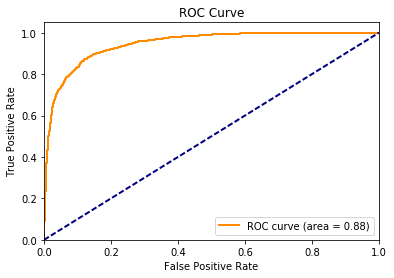

In [121]:
y = train.sentiment.values
best_c_counts = train_and_plot(X_counts, y)

Test runs for X_binary feature

best c is: 0.0046, the best score is : 87.29%
worst c is: 1347.3491, the worst score is : 81.64%, the lift is 5.66%


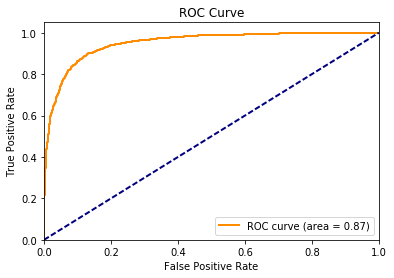

In [122]:
best_c_binary = train_and_plot(X_binary, y)

Test runs for X_tfidf feature

best c is: 0.1065, the best score is : 88.32%
worst c is: 0.0001, the worst score is : 81.20%, the lift is 7.11%


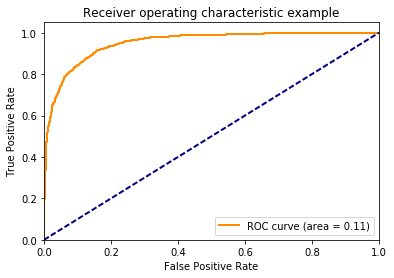

In [82]:
best_c_tfidf = train_and_plot(X_tfidf, y)

Test runs for imbalanced feature

best c is: 0.0339, the best score is : 80.13%
worst c is: 0.0001, the worst score is : 50.59%, the lift is 29.54%


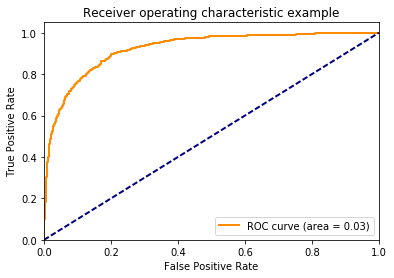

In [102]:
best_c_imbalance = train_and_plot(X_binary_imbalanced, y_label_imbalanced)

Use all training data to train the model, predict the test score

Basic count feature has a Kaggle score of 0.879 

In [97]:
clf = LinearSVC(C=best_c_counts)
clf.fit(X_counts,train.sentiment.values)
kaggle_pred = clf.predict(X_counts_test)
output = pd.DataFrame(data={"id":test["id"], "sentiment":kaggle_pred})
output.to_csv( "Output_counts.csv", index=False, quoting=3)

Binary set has a Kaggle score of 0.876

In [100]:
clf = LinearSVC(C=best_c_binary)
clf.fit(X_binary,train.sentiment.values)
kaggle_pred = clf.predict(X_binary_test)
output = pd.DataFrame(data={"id":test["id"], "sentiment":kaggle_pred})
output.to_csv( "Output_binary.csv", index=False, quoting=3)

Tfidf set has a Kaggle score of 0.884 

In [101]:
clf = LinearSVC(C=best_c_tfidf)
clf.fit(X_tfidf,train.sentiment.values)
kaggle_pred = clf.predict(X_tfidf_test)
output = pd.DataFrame(data={"id":test["id"], "sentiment":kaggle_pred})
output.to_csv( "Output_tfidf.csv", index=False, quoting=3)

Imbalanced set has a Kaggle score of 0.80

In [105]:
clf = LinearSVC(C=best_c_imbalance)
clf.fit(X_binary_imbalanced, y_label_imbalanced)
kaggle_pred = clf.predict(X_binary_test)
output = pd.DataFrame(data={"id":test["id"], "sentiment":kaggle_pred})
output.to_csv( "Output_binary_imbalance.csv", index=False, quoting=3)

So overall the first three model performed in very close levels, with the tfidf one slightly better. The imbalanced one is a little off. Also the model with imbalanced feauture matrix is very sensitive to regularization factor C and there was a big gap between best and worst performance using different C values.

### Part IV
plot the learning curve, using function from sklearn 

In [110]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.005, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

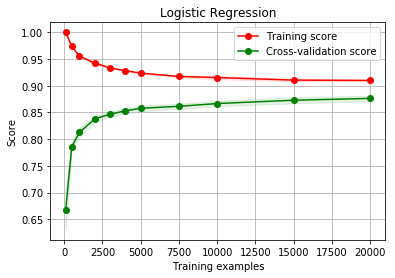

In [115]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C =0.02)
cv = KFold(n_splits=5)
train_sizes = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]
plt = plot_learning_curve(estimator=clf, cv =cv, title="Logistic Regression",X=X_counts, y=y, train_sizes = train_sizes)
plt.show()

So as more training instances are fit into the model, the gap between training score and CV score shrinks. The training score decreases as it's more difficult for model to fit the training set perfectly with more instances. However the model's capability of generalization and prediction increases with more data. The gap indicates that there is still some overfitting with the model. However it seems like the model hasn't reached its full potential and the performance could still rise with more data, although the increase will be very limited as the gap is already fairly small with n = 20000.